In [ ]:
# we will take a whole name as sequence and then we use each single letter and put in our RNN as one input  
import io
import os
import unicodedata
import string
import glob 

import torch
import random

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) # unicodedata.normalize - This separates any accented characters into their base character and the accent mark.
        if unicodedata.category(c) != 'Mn' # Mn-(mark, non-spacing), which includes most accent marks.
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('drive/MyDrive/data_rnn/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories



"""
To represent a single letter, we use a “one-hot vector” of 
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.
To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.
That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)  # zero all the numbers
    for i, letter in enumerate(line):              # using one hot encoding here
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):
    
    # This is a function that randomly selects a category and a line of text from a dataset,
    # and converts them into PyTorch tensors that can be used as input to a neural network
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

# line_tensor = converting line to tensor
# category_tensor = creates a PyTorch tensor containing the index of the category as a long integer. 
# The dtype argument specifies the data type of the tensor to be a long integer.



if __name__ == '__main__':
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))
    
    category_lines, all_categories = load_data()
    print(category_lines['Italian'][:5])
    
    print(letter_to_tensor('J')) # [1, 57]
    print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## RNN

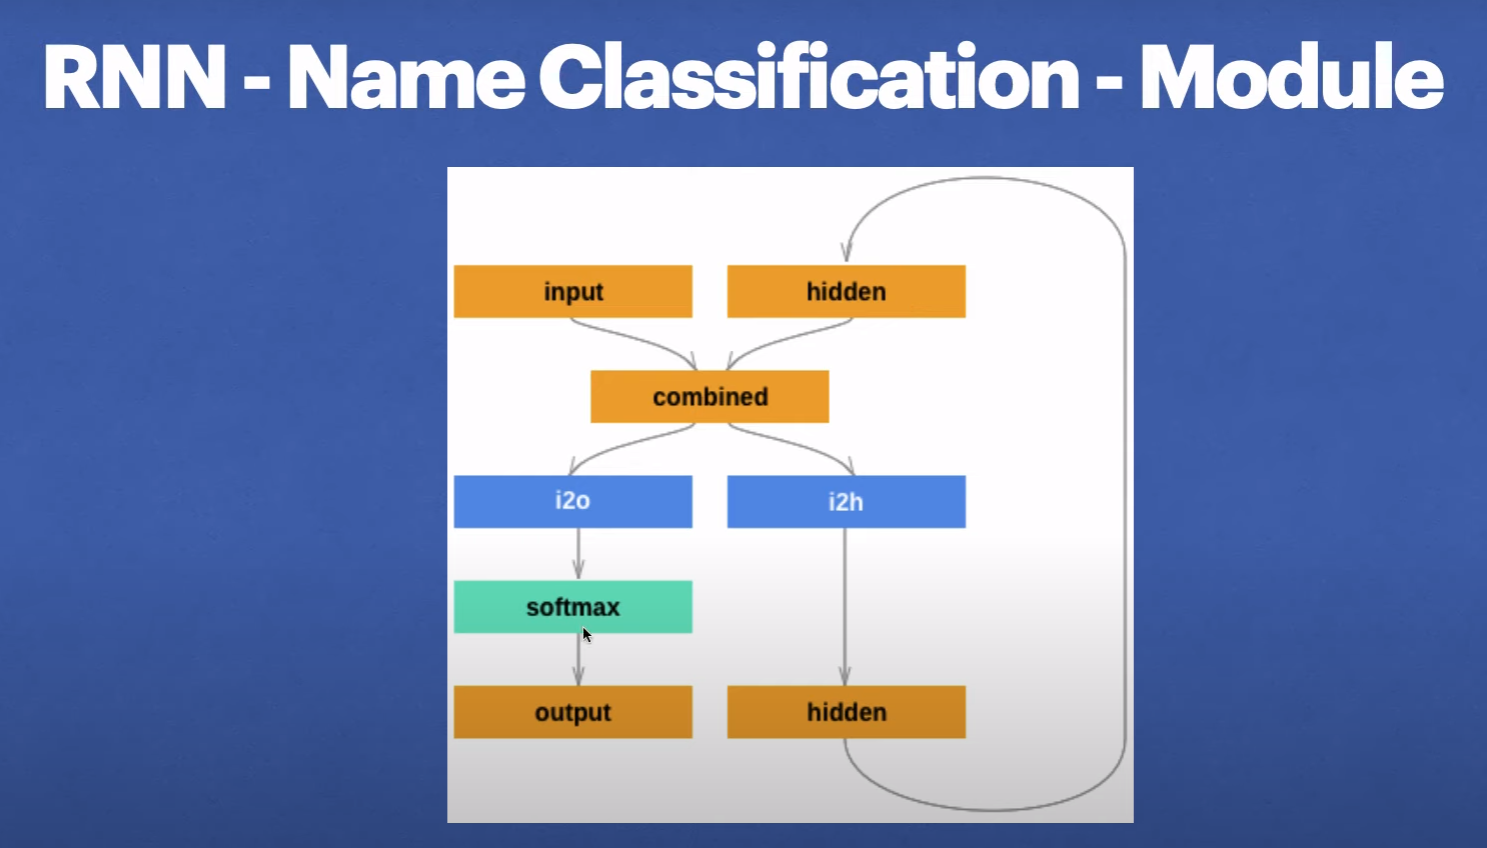

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # input to hidden layer # input addition - see picture
    self.i2o = nn.Linear(input_size + hidden_size, output_size)  # input to output layer # input addition - see picture
    self.softmax = nn.LogSoftmax(dim=1) # becoz input is in shape 1...Ex-(1, 57)

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)

    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output) 
    return output, hidden

  # Helper Function
  def init_hidden(self):   # need some initial hidden state at begining 
    return torch.zeros(1, self.hidden_size) 


In [ ]:
# category_lines is dictionary -> Key: Country, Values: Names
# all_categories -> list of country
category_lines, all_categories = load_data()
n_categories = len(all_categories)
print(n_categories)

18


In [ ]:
n_hidden =128 # try
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [ ]:
# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())


torch.Size([1, 18])
torch.Size([1, 128])


We want to treat our name in one sequence and each single character is one input
repeat it again and again and at the end apply softmax

In [ ]:
## Whole sequence/ name
# converting single character to tensor
input_tensor = line_to_tensor('Chweh')

# rnn.init_hidden() - function initializes the hidden state of the RNN.
hidden_tensor = rnn.init_hidden()

# output tensor contains the output of the RNN after processing the input letter. 
# The next_hidden tensor contains the updated hidden state of the RNN after processing the input letter. 
 # This tensor is used as the input to the RNN for the next time step.

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size()) 
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [ ]:
# Helper Function - used to print the category of output

def category_from_output(output):
  # want to return index of greater value so
  category_idx = torch.argmax(output).item()
  return all_categories[category_idx]

print(category_from_output(output))


Arabic


In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

In [ ]:
# Helper Function for training

# line_tensor = converting line to tensor
# category_tensor = creates a PyTorch tensor containing the index of the category as a long integer. 
# The dtype argument specifies the data type of the tensor to be a long integer.

# train() = This function performs a forward pass through the RNN, 
# computes the loss based on the predicted output and the target output,
# and performs backpropagation to update the model parameters.
def train(line_tensor, category_tensor):
  hidden = rnn.init_hidden() # initialize hidden state

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden) # want line_tensor with current character and next hidden state

  loss = criterion(output, category_tensor) # calculating loss

  optimizer.zero_grad()  # zero thr grad
  loss.backward()        # doing backward pass
  optimizer.step()       # updating weights

  return output, loss.item()

In [ ]:
# Training Loop
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000


for i in range(n_iters):
  category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

  output, loss = train(line_tensor, category_tensor)
  current_loss += loss

  # to find average loss
  if (i+1) % plot_steps == 0:
    all_losses.append(current_loss / plot_steps)
    current_loss = 0
  
  # to guess if it is right then print CORRECT ,
  # if it is wrong then print WRONG and print the correct category
  if (i+1) % print_steps == 0:
    guess = category_from_output(output)
    correct = "CORRECT" if guess == category else f"WRONG ({category})"
    print(f"{i+1} {(i+1) / n_iters*100} {loss:.4f} {line} / {guess} {correct}")

# plot loss figure
#plt.figure()
#plt.plot(all_losses)
#plt.show()


def predict(input_line):
  print(f"\n> {input_line}")
  with torch.no_grad():
    line_tensor = line_to_tensor(input_line)

    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
      output, hidden = rnn(line_tensor[i], hidden)

    guess = category_from_output(output)
    print(guess)

while True:
  sentence = input("Input: ")
  if sentence == "quit":
    break
    
  predict(sentence)

5000 5.0 0.3534 Vennen / Dutch CORRECT
10000 10.0 0.2207 Rompaye / Dutch CORRECT
15000 15.0 1.1941 Chun / Chinese WRONG (Korean)
20000 20.0 0.1178 Slaski / Polish CORRECT
25000 25.0 0.7041 Pena / Spanish CORRECT
30000 30.0 1.2361 Alford / English CORRECT
35000 35.0 6.6123 Renne / Italian WRONG (Russian)
40000 40.0 0.1372 Waclauska / Czech CORRECT
45000 45.0 2.4073 Kings / Dutch WRONG (English)
50000 50.0 0.0284 Fukunaka / Japanese CORRECT
55000 55.00000000000001 3.0631 Smit / French WRONG (Dutch)
60000 60.0 0.6816 Phan / Vietnamese CORRECT
65000 65.0 1.7653 Michalovic / Russian WRONG (Czech)
70000 70.0 1.9477 Mikhail / Czech WRONG (Arabic)
75000 75.0 2.4876 Zini / Chinese WRONG (Italian)
80000 80.0 2.7190 Sala / Spanish WRONG (Italian)
85000 85.0 1.3315 Wirnhier / Chinese WRONG (German)
90000 90.0 1.0250 Sze  / Korean WRONG (Chinese)
95000 95.0 0.4518 Gorchinsky / Russian CORRECT
100000 100.0 0.3484 Huber / German CORRECT
Input: Amersvoort

> Amersvoort
Dutch
Input: Betlach

> Betlach
